<a href="https://colab.research.google.com/github/joaoBernardinoo/avoid-obstacle-collision/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import os
import h5py
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
import joblib
import matplotlib

In [3]:
# @title Plot

def evaluate_and_plot_prediction(y_test, y_pred):
    """
    Calculates errors and generates plots to evaluate prediction performance.

    Args:
        y_test (np.ndarray): Array of real values.
        y_pred (np.ndarray): Array of predicted values.
    """
    errors = y_test - y_pred

    # Plot results
    plt.figure(figsize=(15, 5))

    # Gráfico 1: Predição vs Valor Real
    plt.subplot(131)
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([-2, 2], [-2, 2], 'r--', label='Predição Perfeita')
    plt.title('Predição vs Valor Real')
    plt.xlabel('Valor Real')
    plt.ylabel('Predito')
    plt.grid(True)
    plt.legend()

    # Gráfico 2: Distribuição dos Erros
    plt.subplot(132)
    plt.hist(errors, bins=30, alpha=0.7)
    plt.axvline(0, color='r', linestyle='--')
    plt.title('Distribuição dos Erros')
    plt.xlabel('Erro (Real - Predito)')
    plt.ylabel('Frequência')
    plt.grid(True)

    # Gráfico 3: Valores Reais vs Preditos
    plt.subplot(133)
    sorted_idx = np.argsort(y_test)
    plt.plot(y_test[sorted_idx], label='Valor Real')
    plt.plot(y_pred[sorted_idx], 'r--', alpha=0.7, label='Predição')
    plt.title('Comparação Direta')
    plt.xlabel('Amostras Ordenadas')
    plt.ylabel('Valor')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Avaliação de desempenho
    mae = np.mean(np.abs(errors))
    print(f"\nErro Médio Absoluto (MAE): {mae:.4f}")
    print(f"Acurácia (erro < 0.1): {np.mean(np.abs(errors) < 0.2):.2%}")

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Parameters
n = 10  # Number of input variables (min(a₁, a₂, ..., aₙ))
num_samples = 10000  # Training data size
input_range = (-3.14, 3.14)  # Input values range
import numpy as np

def closest_to_zero(arr):
    if arr.size == 0:
        return None
    idx = np.argmin(np.abs(arr))
    closest = arr[idx]
    return closest

def generate_data(n, num_samples, input_range):
    X = np.random.uniform(input_range[0], input_range[1], size=(num_samples, n))
    y = np.apply_along_axis(closest_to_zero, 1, X)
    return X, y

In [20]:
X, y = generate_data(n, num_samples, input_range)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
params = [
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0.9,
        "nesterovs_momentum": False,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0.9,
        "nesterovs_momentum": True,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "invscaling",
        "momentum": 0,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "invscaling",
        "momentum": 0.9,
        "nesterovs_momentum": False,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "adaptive",
        "momentum": 0.9,
        "nesterovs_momentum": True,
        "learning_rate_init": 0.2,
    },
    {"solver": "lbfgs", "learning_rate_init": 0.01},
    {"solver": "adam", "learning_rate_init": 0.01},
]

In [24]:
from sklearn.neural_network import MLPClassifier

# Transformar em problema multiclasse
y_train_class = np.argmin(np.abs(X_train), axis=1)
mlp = MLPClassifier(hidden_layer_sizes=(100, 50,50), activation='tanh',**params[-2],verbose=True)
mlp.fit(X_train, y_train_class)

# Recuperar a predição
predicted_indices = mlp.predict(X_test)
y_pred = X_test[np.arange(len(X_test)), predicted_indices]

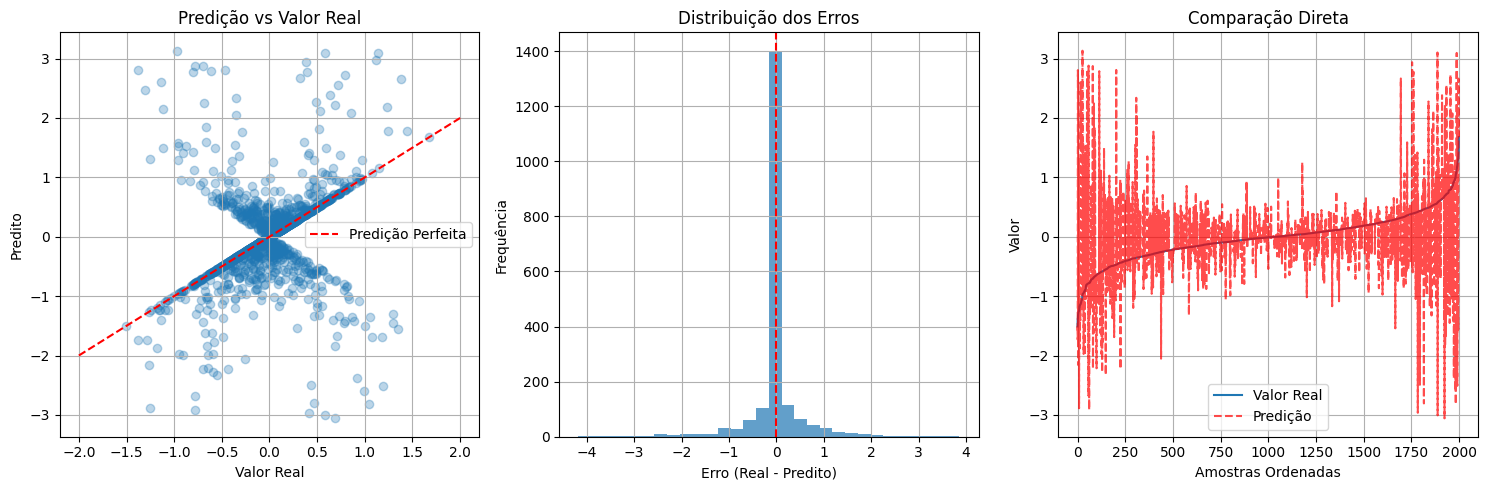


Erro Médio Absoluto (MAE): 0.2573
Acurácia (erro < 0.1): 72.90%


In [22]:
# Example usage of the function with the existing variables
evaluate_and_plot_prediction(y_test, y_pred)

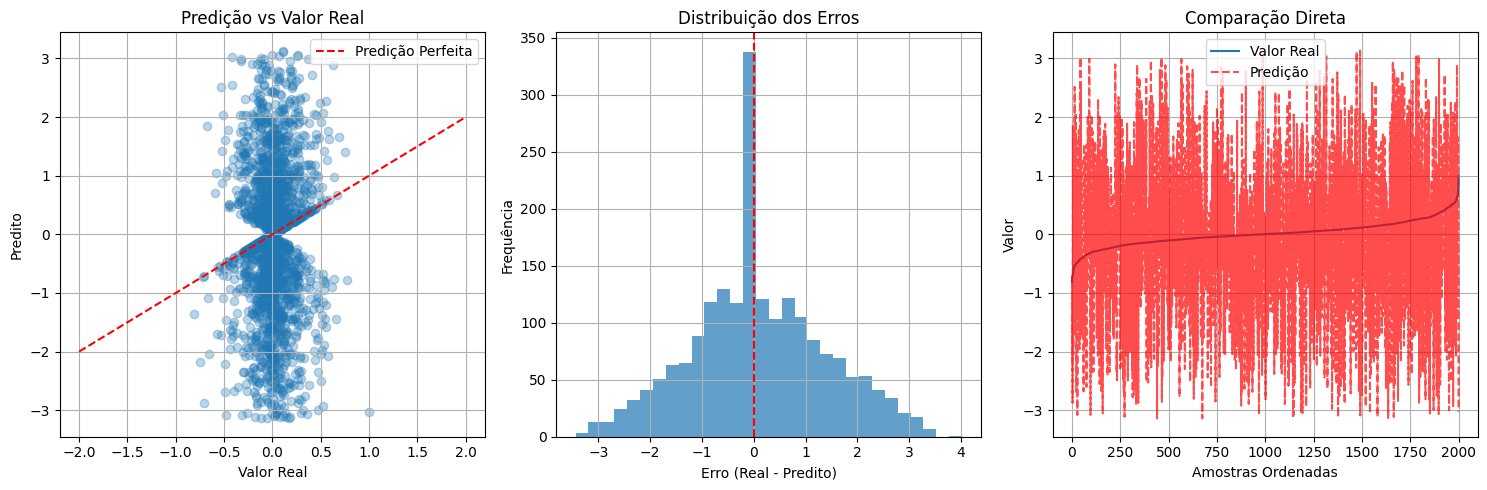


Erro Médio Absoluto (MAE): 0.9989
Acurácia (erro < 0.1): 20.85%


In [12]:
evaluate_and_plot_prediction(y_test, y_pred)


In [26]:

# save
joblib.dump(mlp, "model.pkl")

mlp2 = joblib.load("model.pkl")

In [25]:
# Build the MLP
model = Sequential([
    Dense(128, activation='relu', input_shape=(n,)),  # Hidden layer 1
    Dense(64, activation='relu'),                   # Hidden layer 2
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),                   # Hidden layer 3 (optional)
    # Hidden layer 3 (optional)
    Dense(1)                                       # Linear output
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae'])

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64
)

/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1752445722.262321  298926 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2546 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5
2025-07-13 19:28:42.478104: W external/local_xla/xla/service/gpu/llvm_gpu_backend/default/nvptx_libdevice_path.cc:40] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  

Epoch 1/50


I0000 00:00:1752445723.857022  365338 service.cc:152] XLA service 0x7f34380047f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752445723.857037  365338 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-07-13 19:28:43.880444: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752445724.135913  365338 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-07-13 19:28:44.198559: W external/local_xla/xla/stream_executor/gpu/redzone_allocator_kernel_cuda.cc:135] NOT_FOUND: Couldn't find a suitable version of ptxas. The following locations were considered: bin/ptxas, /home/dino/Documents/ia/.venv/bin/ptxas, /usr/local/sbin/ptxas, /usr/local/bin/ptxas, /usr/bin/ptxas, /usr/bin/site_perl/ptxas, /usr/bin/vendor_perl/ptxas, /usr/bin/core_perl/ptxas, ipykernel_launcher.runfiles/cuda_n

UnavailableError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 211, in start

  File "/home/dino/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/home/dino/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/home/dino/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3116, in run_cell

  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3171, in _run_cell

  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3394, in run_cell_async

  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3639, in run_ast_nodes

  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3699, in run_code

  File "/tmp/ipykernel_298926/1421220066.py", line 16, in <module>

  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

No PTX compilation provider is available. Neither ptxas/nvlink nor nvjtlink is available. As a fallback you can enable JIT compilation in the CUDA driver via the flag `--xla_gpu_unsafe_fallback_to_driver_on_ptxas_not_found`. Details: 
 - Has NvJitLink support: LibNvJitLink is not supported (disabled during compilation).
 - Has NvPtxCompiler support: LibNvPtxCompiler is not supported (disabled during compilation).
 - Parallel compilation support is desired: 0
 - ptxas_path: Couldn't find a suitable version of ptxas. The following locations were considered: ./cuda_sdk_lib/bin/ptxas, /home/dino/Documents/ia/.venv/bin/ptxas, /usr/local/sbin/ptxas, /usr/local/bin/ptxas, /usr/bin/ptxas, /usr/bin/site_perl/ptxas, /usr/bin/vendor_perl/ptxas, /usr/bin/core_perl/ptxas, ipykernel_launcher.runfiles/cuda_nvcc/bin/ptxas, ipykern/cuda_nvcc/bin/ptxas, bin/ptxas, /usr/local/cuda/bin/ptxas, /opt/cuda/bin/ptxas, /home/dino/Documents/ia/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc/bin/ptxas, /home/dino/Documents/ia/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc/bin/ptxas, /home/dino/Documents/ia/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../cuda/bin/ptxas, /home/dino/Documents/ia/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../../../../bin/ptxas, /home/dino/Documents/ia/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../../../../../bin/ptxas
 - ptxas_version: Couldn't find a suitable version of ptxas. The following locations were considered: ./cuda_sdk_lib/bin/ptxas, /home/dino/Documents/ia/.venv/bin/ptxas, /usr/local/sbin/ptxas, /usr/local/bin/ptxas, /usr/bin/ptxas, /usr/bin/site_perl/ptxas, /usr/bin/vendor_perl/ptxas, /usr/bin/core_perl/ptxas, ipykernel_launcher.runfiles/cuda_nvcc/bin/ptxas, ipykern/cuda_nvcc/bin/ptxas, bin/ptxas, /usr/local/cuda/bin/ptxas, /opt/cuda/bin/ptxas, /home/dino/Documents/ia/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc/bin/ptxas, /home/dino/Documents/ia/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc/bin/ptxas, /home/dino/Documents/ia/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../cuda/bin/ptxas, /home/dino/Documents/ia/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../../../../bin/ptxas, /home/dino/Documents/ia/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../../../../../bin/ptxas
 - nvlink_path: Couldn't find a suitable version of nvlink. The following locations were considered: ./cuda_sdk_lib/bin/nvlink, /home/dino/Documents/ia/.venv/bin/nvlink, /usr/local/sbin/nvlink, /usr/local/bin/nvlink, /usr/bin/nvlink, /usr/bin/site_perl/nvlink, /usr/bin/vendor_perl/nvlink, /usr/bin/core_perl/nvlink, ipykernel_launcher.runfiles/cuda_nvcc/bin/nvlink, ipykern/cuda_nvcc/bin/nvlink, bin/nvlink, /usr/local/cuda/bin/nvlink, /opt/cuda/bin/nvlink, /home/dino/Documents/ia/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc/bin/nvlink, /home/dino/Documents/ia/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc/bin/nvlink, /home/dino/Documents/ia/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../cuda/bin/nvlink, /home/dino/Documents/ia/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../../../../bin/nvlink, /home/dino/Documents/ia/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../../../../../bin/nvlink
 - nvlink_version: Couldn't find a suitable version of nvlink. The following locations were considered: ./cuda_sdk_lib/bin/nvlink, /home/dino/Documents/ia/.venv/bin/nvlink, /usr/local/sbin/nvlink, /usr/local/bin/nvlink, /usr/bin/nvlink, /usr/bin/site_perl/nvlink, /usr/bin/vendor_perl/nvlink, /usr/bin/core_perl/nvlink, ipykernel_launcher.runfiles/cuda_nvcc/bin/nvlink, ipykern/cuda_nvcc/bin/nvlink, bin/nvlink, /usr/local/cuda/bin/nvlink, /opt/cuda/bin/nvlink, /home/dino/Documents/ia/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc/bin/nvlink, /home/dino/Documents/ia/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc/bin/nvlink, /home/dino/Documents/ia/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../cuda/bin/nvlink, /home/dino/Documents/ia/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../../../../bin/nvlink, /home/dino/Documents/ia/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../../../../../bin/nvlink
 - Driver compilation is enabled: 0

	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_1880]

In [31]:
y_pred = model.predict(X_test,verbose=0)
y_pred = np.squeeze(y_pred)

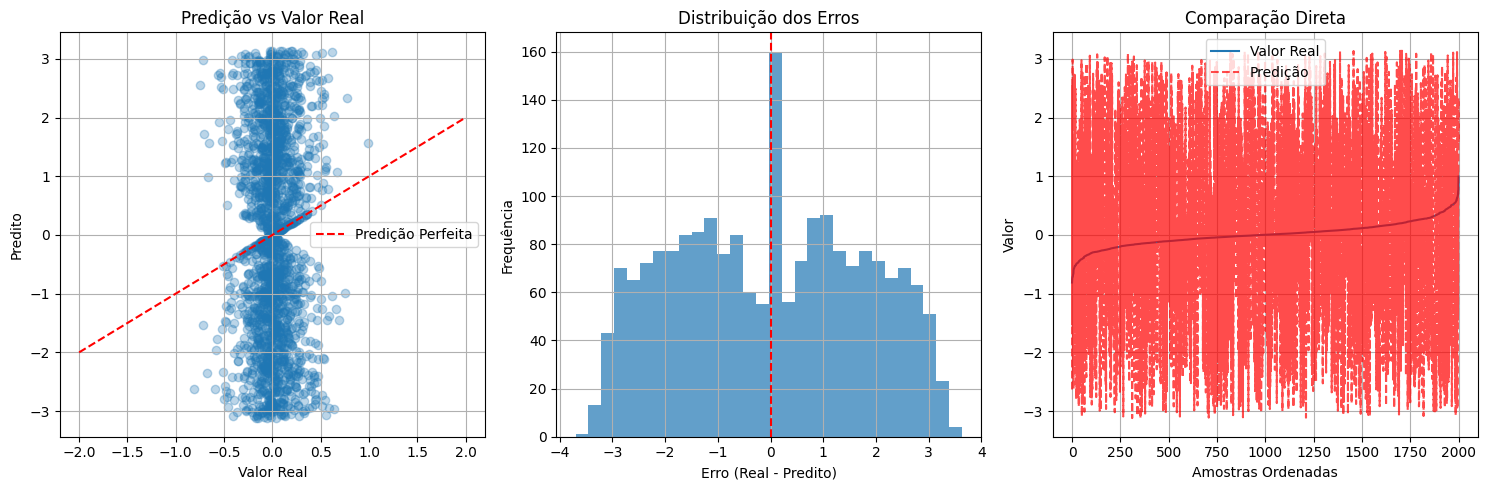


Erro Médio Absoluto (MAE): 1.5064
Acurácia (erro < 0.1): 9.70%


In [20]:
evaluate_and_plot_prediction(y_test, y_pred)
